In [89]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score , confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier

import joblib
import os


In [90]:
df = pd.read_csv("data/data_clean.csv")

In [91]:
TARGET = "default.payment.next.month"

X = df.drop(columns=[TARGET])
y = df[TARGET]

In [92]:
print(X.shape, y.value_counts())

(30000, 22) default.payment.next.month
0    23364
1     6636
Name: count, dtype: int64


In [147]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.3,
    random_state=90,
    stratify=y
)

In [148]:
X_train.shape

(21000, 22)

In [149]:
X_val.shape

(9000, 22)

In [150]:
y_train.value_counts(normalize=True)

default.payment.next.month
0    0.77881
1    0.22119
Name: proportion, dtype: float64

In [151]:
y_val.value_counts(normalize=True)

default.payment.next.month
0    0.778778
1    0.221222
Name: proportion, dtype: float64

In [152]:
classes = y_train.unique()

In [153]:
weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train
)

In [154]:
class_weights = dict(zip(classes, weights))

In [155]:
class_weights 

{np.int64(0): np.float64(0.6420055029043106),
 np.int64(1): np.float64(2.2604951560818085)}

In [156]:
lgb_model = lgb.LGBMClassifier(
    n_estimators=500,
    learning_rate=0.01,
    max_depth=-1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight=class_weights,
    random_state=42
)

lgb_model.fit(X_train, y_train)

lgb_pred = lgb_model.predict_proba(X_val)[:, 1]
lgb_auc = roc_auc_score(y_val, lgb_pred)

print("LightGBM ROC-AUC:", lgb_auc)

[LightGBM] [Info] Number of positive: 4645, number of negative: 16355
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003622 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2695
[LightGBM] [Info] Number of data points in the train set: 21000, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
LightGBM ROC-AUC: 0.7852694093029132


In [157]:
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb_model = xgb.XGBClassifier(
    n_estimators=500,
    learning_rate=0.01,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    eval_metric="auc",
    random_state=42
)

xgb_model.fit(X_train, y_train)

xgb_pred = xgb_model.predict_proba(X_val)[:, 1]
xgb_auc = roc_auc_score(y_val, xgb_pred)

print("XGBoost ROC-AUC:", xgb_auc)


XGBoost ROC-AUC: 0.7843171644349923


In [158]:
cat_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.01,
    depth=6,
    loss_function="Logloss",
    eval_metric="AUC",
    class_weights=class_weights,
    verbose=0,
    random_state=42
)

cat_model.fit(X_train, y_train)

cat_pred = cat_model.predict_proba(X_val)[:, 1]
cat_auc = roc_auc_score(y_val, cat_pred)

print("CatBoost ROC-AUC:", cat_auc)


CatBoost ROC-AUC: 0.7848175972931123


In [159]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [160]:
n_features = X_train_scaled.shape[1]
nn_model = Sequential([
    Dense(32, activation='relu', input_shape=(n_features,)),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

e:\Bureau\imaneeeee\Credit-Card-Default-Prediction\proENv\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [161]:
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

In [162]:
early_stop = EarlyStopping(monitor='val_auc', mode='max', patience=5, restore_best_weights=True)

In [163]:
nn_model.fit(X_train_scaled, 
             y_train, validation_data=(X_val_scaled, y_val),
             epochs=50, 
             batch_size=32, 
             class_weight=class_weights,
             callbacks=[early_stop], verbose=0)


e:\Bureau\imaneeeee\Credit-Card-Default-Prediction\proENv\Lib\site-packages\keras\src\callbacks\early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: AUC,loss,val_AUC,val_loss
  current = self.get_monitor_value(logs)


In [164]:
# Predictions
nn_pred = nn_model.predict(X_val_scaled)[:,0]

282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [165]:
nn_auc = roc_auc_score(y_val, nn_pred)

print("Neural Network ROC-AUC:", nn_auc)

Neural Network ROC-AUC: 0.7579453166299281


In [166]:
print("=== MODEL PERFORMANCE ===")
print("LightGBM AUC : ", lgb_auc)
print("XGBoost AUC  : ",xgb_auc)
print("CatBoost AUC : ",cat_auc)
print("Neural Network ROC-AUC:", nn_auc)

=== MODEL PERFORMANCE ===
LightGBM AUC :  0.7852694093029132
XGBoost AUC  :  0.7843171644349923
CatBoost AUC :  0.7848175972931123
Neural Network ROC-AUC: 0.7579453166299281


In [167]:
X_val['lgb_pred'] = lgb_pred
X_val['xgb_pred'] = xgb_pred
X_val['cat_pred'] = cat_pred
X_val['nn_pred'] = nn_pred
stacking_df = X_val.copy()

In [168]:
X_meta = stacking_df
y_meta = y_val.reset_index(drop=True)

In [169]:
meta_model = Ridge()
meta_model.fit(X_meta, y_meta)

,"alpha alpha: {float, ndarray of shape (n_targets,)}, default=1.0Constant that multiplies the L2 term, controlling regularizationstrength. `alpha` must be a non-negative float i.e. in `[0, inf)`.When `alpha = 0`, the objective is equivalent to ordinary leastsquares, solved by the :class:`LinearRegression` object. For numericalreasons, using `alpha = 0` with the `Ridge` object is not advised.Instead, you should use the :class:`LinearRegression` object.If an array is passed, penalties are assumed to be specific to thetargets. Hence they must correspond in number.",1.0
,"fit_intercept fit_intercept: bool, default=TrueWhether to fit the intercept for this model. If setto false, no intercept will be used in calculations(i.e. ``X`` and ``y`` are expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"max_iter max_iter: int, default=NoneMaximum number of iterations for conjugate gradient solver.For 'sparse_cg' and 'lsqr' solvers, the default value is determinedby scipy.sparse.linalg. For 'sag' solver, the default value is 1000.For 'lbfgs' solver, the default value is 15000.",None
,"tol tol: float, default=1e-4The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for each solver:- 'svd': `tol` has no impact.- 'cholesky': `tol` has no impact.- 'sparse_cg': norm of residuals smaller than `tol`.- 'lsqr': `tol` is set as atol and btol of scipy.sparse.linalg.lsqr, which control the norm of the residual vector in terms of the norms of matrix and coefficients.- 'sag' and 'saga': relative change of coef smaller than `tol`.- 'lbfgs': maximum of the absolute (projected) gradient=max|residuals| smaller than `tol`... versionchanged:: 1.2 Default value changed from 1e-3 to 1e-4 for consistency with other linear models.",0.0001
,"solver solver: {'auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs'}, default='auto'Solver to use in the computational routines:- 'auto' chooses the solver automatically based on the type of data.- 'svd' uses a Singular Value Decomposition of X to compute the Ridge coefficients. It is the most stable solver, in particular more stable for singular matrices than 'cholesky' at the cost of being slower.- 'cholesky' uses the standard :func:`scipy.linalg.solve` function to obtain a closed-form solution.- 'sparse_cg' uses the conjugate gradient solver as found in :func:`scipy.sparse.linalg.cg`. As an iterative algorithm, this solver is more appropriate than 'cholesky' for large-scale data (possibility to set `tol` and `max_iter`).- 'lsqr' uses the dedicated regularized least-squares routine :func:`scipy.sparse.linalg.lsqr`. It is the fastest and uses an iterative procedure.- 'sag' uses a Stochastic Average Gradient descent, and 'saga' uses its improved, unbiased version named SAGA. Both methods also use an iterative procedure, and are often faster than other solvers when both n_samples and n_features are large. Note that 'sag' and 'saga' fast convergence is only guaranteed on features with approximately the same scale. You can preprocess the data with a scaler from :mod:`sklearn.preprocessing`.- 'lbfgs' uses L-BFGS-B algorithm implemented in :func:`scipy.optimize.minimize`. It can be used only when `positive` is True.All solvers except 'svd' support both dense and sparse data. However, only'lsqr', 'sag', 'sparse_cg', and 'lbfgs' support sparse input when`fit_intercept` is True... versionadded:: 0.17 Stochastic Average Gradient descent solver... versionadded:: 0.19 SAGA solver.",'auto'
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive.Only 'lbfgs' solver is supported in this case.",False
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag' or 'saga' to shuffle the data.See :term:`Glossary ` for details... versionadded:: 0.17 `random_state` to support Stochastic Average Gradient.",None


In [170]:
meta_pred = meta_model.predict(X_meta)
meta_auc = roc_auc_score(y_meta, meta_pred)
print("Meta-Model ROC-AUC:", meta_auc)

Meta-Model ROC-AUC: 0.7874407941744413


Confusion Matrix (Meta-Model):
[[6638  371]
 [1255  736]]

Classification Report (Meta-Model):
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      7009
           1       0.66      0.37      0.48      1991

    accuracy                           0.82      9000
   macro avg       0.75      0.66      0.68      9000
weighted avg       0.80      0.82      0.80      9000



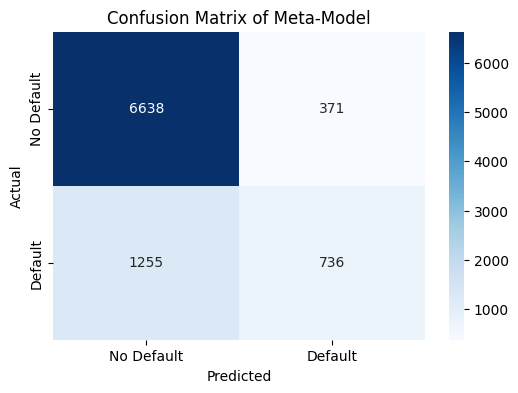

In [171]:
#  Confusion Matrix for Meta-Model

meta_class = np.round(meta_pred).astype(int)  # 0.5 threshold

cm = confusion_matrix(y_meta, meta_class)
print("Confusion Matrix (Meta-Model):")
print(cm)

print("\nClassification Report (Meta-Model):")
print(classification_report(y_meta, meta_class))

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["No Default", "Default"],
            yticklabels=["No Default", "Default"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix of Meta-Model")
plt.show()



In [ ]:
stacking_df.to_csv("outputs/stacking_level1.csv", index=False)